# Offline Evaluation

After pre-processing our data, we obtain 2 separate datasets, one for Las Vegas, one for Toronto and now we are ready to perform offline evaluation.

In [27]:
# Imported required packages
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import List
from tqdm import tqdm

import random
import numpy as np
import pandas as pd
from scipy.stats import beta
import matplotlib.pyplot as plt


# Setting plot size, plot style & random seed
plt.rcParams["figure.figsize"] = (20,10)
plt.style.use('ggplot')
random.seed(1)

## Defining Bandit Algorithms

First, we define all the bandit algorithms that we will use, including contextual bandits. We will make use of OOP and abstract classes to ensure that all the bandit algorithms use a similar API with the same methods defined to select an arm and update reward. This will make easy when performing evaluation replay.

In [28]:
class BanditAlgorithm(ABC):
    """
    Abstract class to capture common behaviours among different types of bandit algorithms.
    
    As much as possible, NumPy operations are used to improve runtime.
    
    select_arm will depend on specific bandit algorithm and is left as an abstract method.
    """
    
    def set_arms(self, n_arms: int) -> BanditAlgorithm:
        """
        Method to set counts & values if previously not initialised
        
        :param n_arms: Number of arms in the simulation
        :return: Self
        """
        self.counts = np.full(n_arms, 0, dtype=int)
        self.values = np.full(n_arms, 0.0)
        return self
    
    @abstractmethod
    def select_arm(self) -> int:
        """
        Method to select arm
        
        :return: Index of chosen arm
        """
        raise NotImplementedError
    
    def update(self, chosen_arm: int, reward: float) -> BanditAlgorithm:
        """
        Method to update counts & values after choosing an arm and obtaining a reward
        
        :param chosen_arm: Index of chosen arm
        :param reward: Reward earned from arm
        :return: Self
        """
        # Updating counts
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        
        # Updating value
        new_value = (((n - 1) / float(n)) * value) + ((1 / float(n)) * reward)
        self.values[chosen_arm] = new_value
        return self
    
    def __str__(self) -> str:
        # Return name of algorithm, for plotting graphs
        return self.__class__.__name__                                    

In [29]:
class EpsilonGreedy(BanditAlgorithm):
    """
    Epsilon-greedy bandit algorithm
    """
    
    def __init__(self, epsilon: float = 0.1) -> None:
        # Default epsilon is 0.1
        self.epsilon = epsilon
        return
    
    def select_arm(self) -> int:
        # Observe if this step will be exploration or exploitation
        if random.random() > self.epsilon:
            # If exploit, select best arm
            return np.argmax(self.values)
        else:
            # If explore, select random arm
            return random.randrange(len(self.values))
    
    def __str__(self) -> str:
        return super().__str__() + f" with epsilon={self.epsilon}"

In [30]:
class EpsilonDecay(BanditAlgorithm):
    """
    Epsilon-decay bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Calculate epsilon
        epsilon = 1 / ((sum(self.counts) / len(self.counts)) + 1)
        
        # Observe if this step will be exploration or exploitation
        if random.random() > epsilon:
            # If exploit, select best arm
            return np.argmax(self.values)
        else:
            # If explore, select random arm
            return random.randrange(len(self.values))

In [31]:
class Softmax(BanditAlgorithm):
    """
    Softmax bandit algorithm
    """
    
    def __init__(self, tau: float = 0.1) -> None:
        # Default temperature is 0.1
        self.tau = tau
        return
    
    def select_arm(self) -> int:
        # Calcualte proability
        exp_vals = np.exp(self.values / self.tau)
        pi = exp_vals / np.sum(exp_vals)
        
        # Draw arm based on probability
        choice = np.random.choice(len(self.values), p=pi)
        return choice
    
    def __str__(self) -> str:
        return super().__str__() + f" with temperature={self.tau}"

In [32]:
class AnnealingSoftmax(BanditAlgorithm):
    """
    Annealing softmax bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Calculate temperature
        tau = 1 / ((sum(self.counts) / len(self.counts)) + 1)
        
        # Calcualte proability
        exp_vals = np.exp(self.values / tau)
        pi = exp_vals / np.sum(exp_vals)
        
        # Draw arm based on probability
        choice = np.random.choice(len(self.values), p=pi)
        return choice

In [33]:
class UCB(BanditAlgorithm):
    """
    Upper confidence bound bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Ensure that each arm has been played at least once
        for arm, count in enumerate(self.counts):
            if count == 0:
                return arm     

        total_count = sum(self.counts)
        # Calculate curiousity bonus which allows for exploration
        bonus = np.sqrt(2 * np.log(total_count) / self.counts)
        # Calculate the ucb of each arm
        ucb_values = self.values + bonus
        
        # Return arm with highest ucb
        return np.argmax(ucb_values)

In [34]:
class BetaBandit(BanditAlgorithm):
    """
    Abstract bandit algorithm class for BayesianUCB & Thompson Sampling, both utilise Beta distribution for prior distribution
    """
    
    def __init__(self
                 , prior_alpha: float = 1.0
                 , prior_beta: float = 1.0
                 ) -> None:
        super().__init__()
        # Uniform priors will be the default
        self.prior_alpha = prior_alpha
        self.prior_beta = prior_beta
        return
    
    def set_arms(self, n_arms: int) -> BanditAlgorithm:
        self.alphas = np.full(n_arms, self.prior_alpha)
        self.betas = np.full(n_arms, self.prior_beta)
        super().set_arms(n_arms)
        return self
    
    def update(self, chosen_arm: int, reward: float) -> BanditAlgorithm:
        # Updating counts & values
        super().update(chosen_arm, reward)
        # Updating alphas & betas
        self.alphas[chosen_arm] += reward
        self.betas[chosen_arm] += (1 - reward)
        return self

In [35]:
class BayesianUCB(BetaBandit):
    """
    Bayesian upper confidence bound bandit algorithm
    """
    
    def __init__(self
                 , prior_alpha: float = 1.0
                 , prior_beta: float = 1.0
                 , stdnum: float = 3.0
                 ) -> None:
        super().__init__(prior_alpha, prior_beta)
        self.stdnum = stdnum
        return
    
    def select_arm(self) -> int:
        # Calculate the ucb of each arm
        
        # Calculate mean of beta distribution
        expected_rewards = self.alphas / (self.alphas + self.betas)
        # Calculate curiousity bonus which allows for exploration
        bonus = beta.std(self.alphas, self.betas) * self.stdnum
        ucb_values = expected_rewards + bonus
        
        # Return arm with highest ucb
        return np.argmax(ucb_values)
    
    def __str__(self) -> str:
        return super().__str__() + f" with stdnum={self.stdnum}"

In [36]:
class ThompsonSampling(BetaBandit):
    """
    Thompson sampling bandit algorithm
    """
    
    def select_arm(self) -> int:
        # Calculate theta values for each arm
        theta_values = np.random.beta(self.alphas, self.betas)
        
        # Return arm with highest theta
        return np.argmax(theta_values)

In [37]:
class ContextualBandit(BanditAlgorithm):
    """
    Abstract class for contextual bandits, select_arm and update methods take an additional input, context.
    """
    
    def set_arms(self, n_arms: int, n_features: int) -> BanditAlgorithm:
        self.n_features = n_features
        
        # A stores covariance matrix of features seen by arm, initialised as identity matrix
        self.A = np.tile(np.eye(n_features), (n_arms, 1, 1))
        # b stores sum of rewards, or 'Y' in the case of a linear model, for each arm
        self.b = np.zeros((n_arms, n_features))
        return self
    
    @abstractmethod
    def select_arm(self, context: np.ndarray) -> int:
        """
        Method to select arm, given current context
        
        :param context: Array containing values of each feature at current time step
        :return: Index of chosen arm
        """
        raise NotImplementedError
    
    def update(self
               , chosen_arm: int
               , reward: float
               , context: np.ndarray
               ) -> BanditAlgorithm:
        """
        Method to update counts & values after choosing an arm and obtaining a reward, given current context
        
        :param chosen_arm: Index of chosen arm
        :param reward: Reward earned from arm
        :param context: Array containing values of each feature at current time step
        :return: Self
        """
        # Updating A and b
        self.A[chosen_arm] += np.outer(context, context)
        self.b[chosen_arm] += reward * context
        return self

In [38]:
class LinUCB(ContextualBandit):
    """
    Linear UCB contextual bandit algorithm
    """
    
    def __init__(self, alpha: float = 0.1) -> None:
        # alpha will determine level of exploration, default is 0.1
        self.alpha = alpha
        return
    
    def set_arms(self
                 , n_arms: int
                 , n_features: int
                 ) -> BanditAlgorithm:  
        
        super().set_arms(n_arms, n_features)
        
        # theta refers to the regression coefficients, recall OLS solution
        # theta does not change at each call to select_arm, as it does not depend on context, so we can store as attribute to avoid duplicate computations
        self.theta = np.zeros((n_arms, n_features))
        
        return self
    
    def select_arm(self, context: np.ndarray) -> int:
        n_arms = self.A.shape[0]
        p_arms = np.zeros(n_arms)
        
        for arm in range(n_arms):
            # Calculating scores for each arm's linear model, including exploration bonus
            p_arms[arm] = (
                (context @ self.theta[arm]) 
                + (self.alpha * 
                    np.sqrt(context.transpose() 
                            @ np.linalg.inv(self.A[arm])
                            @ context))
            )
        # Return arm with highest score
        return np.argmax(p_arms)
    
    def update(self
               , chosen_arm: int
               , reward: float
               , context: np.ndarray
               ) -> BanditAlgorithm:
        super().update(chosen_arm, reward, context)
        
        # Getting inverse of the covariance matrix of chosen arm's linear model
        A_inv = np.linalg.inv(self.A[chosen_arm])
        # Calculating weight vector for chosen arm's linear model
        self.theta[chosen_arm] = A_inv @ self.b[chosen_arm]
        return self
    
    def __str__(self) -> str:
        return super().__str__() + f" with alpha={self.alpha}"

In [39]:
class ContextualThompsonSampling(ContextualBandit):
    """
    Contextual Thompson Sampling with linear payoff
    """
    
    def __init__(self
                 , delta: float = 0.5
                 , epsilon: float = 0.5
                 , R: float = 0.01
                 ) -> None:
        # Defaults follow example implementation
        self.delta = delta
        self.epsilon = epsilon
        self.R = R
        return
    
    def set_arms(self, n_arms: int, n_features: int) -> BanditAlgorithm:
        super().set_arms(n_arms, n_features)
        
        # v is fixed, we can store as attribute to avoid duplicate computations
        self.v = self.R * np.sqrt(
                24 / self.epsilon * self.n_features * np.log(1 / self.delta)
            )
        # mu_hat does not change at each call to select_arm, as it does not depend on context, so we can store as attribute to avoid duplicate computations
        self.mu_hat = np.zeros((n_arms, n_features))
        return self
    
    def select_arm(self, context: np.ndarray) -> int:
        n_arms = self.A.shape[0]
        scores = np.zeros(n_arms)
        
        for arm in range(n_arms):
            # Sampling mu_tilde for Gaussian distribution, exploration bonus arises from v
            mu_tilde = np.random.multivariate_normal(
                self.mu_hat[arm], (self.v ** 2) * np.linalg.inv(self.A[arm])
                )
            # Calculating score for each arm
            scores[arm] = context.transpose() @ mu_tilde
        
        # Return arm with highest score
        return np.argmax(scores)
    
    def update(self
               , chosen_arm: int
               , reward: float
               , context: np.ndarray
               ) -> BanditAlgorithm:
        super().update(chosen_arm, reward, context)
        
        # Getting inverse of the covariance matrix of chosen arm
        A_inv = np.linalg.inv(self.A[chosen_arm])
        # Calculating mu_hat for chosen arm
        self.mu_hat[chosen_arm] = A_inv @ self.b[chosen_arm]
        return self
    
    def __str__(self) -> str:
        return super().__str__() + f" with delta={self.delta}, epsilon={self.epsilon}, R={self.R}"

## Defining evaluation replay

Here we define the code that will perform evaluation replay.

In [40]:
def evaluation_replay(
    algos: List[BanditAlgorithm]
    , data: pd.DataFrame
    , context_cols: List[str]
    ) -> pd.DataFrame:
    """
    Function to perform evaluation replay with multiple bandit algorithms, including contextual bandits
    
    Results will contain policy, reward, cumulative reward for each time step
    
    :param algos: List of bandit algorithms to run
    :param data: DataFrame with 'business_id' as arm, 'stars' as reward
    :param context_cols: List of column names of the context features
    :return: DataFrame containg results
    """
    # Results will initially be collected as list of dictionaries
    results = []
    
    # Count number of reviews
    n = data.shape[0]
    # Count number of arms
    n_arms = data['business_id'].nunique()
    # Excluding all non-context columns
    context_df = data[context_cols]
    # Count number of features
    n_features = context_df.shape[1]
    
    # Note that bandit algorithms use arm as indexes, so we need to factorize 'business_id' into integer keys
    arm_id_series, business_id_order = pd.factorize(data['business_id'])
    data['arm_id'] = arm_id_series
    
    # Randomly shuffle data, as original data was in sequence of business_id
    data = data.sample(frac=1).reset_index(drop=True)
    
    for algo in algos:
        # Initialising arms
        if isinstance(algo, ContextualBandit):
            algo.set_arms(n_arms, n_features)
        else:
            algo.set_arms(n_arms)
        
        # Cumulative reward starts at 0 for new bandit algorithm
        cumulative_reward = 0.0
        for t in tqdm(range(n), desc=f'Running {str(algo)}'):
            # Extract context at current time step
            context = context_df.iloc[t].to_numpy()
            
            # Draw arm
            if isinstance(algo, ContextualBandit):
                chosen_arm = algo.select_arm(context)
            else:
                chosen_arm = algo.select_arm()
            
            # Compare to actual arm
            actual_arm = data.iloc[t]['arm_id']
            if chosen_arm == actual_arm:
                # Update algorithm with reward if chosen arm matches actual arm
                reward = data.iloc[t]['stars']
                if isinstance(algo, ContextualBandit):
                    algo.update(chosen_arm, reward, context)
                else:
                    algo.update(chosen_arm, reward)
                
                # Updating cumulative reward
                cumulative_reward += reward
                
                # Appending results at current step
                current_step = {
                    'policy': str(algo),
                    'time_step': t,
                    'business_id': data.iloc[t]['business_id'],
                    'reward': reward,
                    'cumulative_reward': cumulative_reward
                }
                results.append(current_step)
    
    # Converting to DataFrame
    results_df = pd.DataFrame(results)
    # Calculating average reward
    results_df['average_reward'] = (
        results_df['cumulative_reward'] / (results_df['time_step'] + 1)
        ).fillna(value=0.0)
    return results_df
                

Here is a function that will help us visualize our results later

In [41]:
def present_results(data: pd.DataFrame, target_metric: str) -> None:
    """
    Helper function to plot results, x-axis will be time_step
    
    :param data: DataFrame containg results of simulation
    :param target_metric: Metric to plot on y-axis
    """
    fig, ax = plt.subplots()
    # Set of colors for plot labels, currently hardcoded for 14 plots only
    colors = ['b', 'g', 'r', 'c', 'm', 'k', 'yellow', 'darkorange', 'blueviolet', 'lime', 'slategrey', 'hotpink', 'maroon', 'deepskyblue']
    
    # Collect names of algorithm
    algo_names = data['policy'].unique().tolist()
    for i, algo_name in enumerate(algo_names):      
        
        # Filter results for that algorithm
        algo_result = data[data['policy'] == algo_name]
        ax.plot(
            algo_result['time_step']
            , algo_result[target_metric]
            , label=algo_name
            , color=colors[i])
    plt.legend()
    plt.title(f"{target_metric} at each step")

## Performing evaluation replay

Now we are ready to load our data. From our preprocessing, the data is saved as a csv so we will load it here.

In [42]:
# Extracting relevant columns
cuisine_cols = [
    'American',
    'Asian Fusion',
    'Bakeries',
    'Bars',
    'Breakfast & Brunch',
    'British',
    'Buffets',
    'Burgers',
    'Cafes',
    'Caterers',
    'Chinese',
    'Desserts',
    'French',
    'Italian',
    'Japanese',
    'Korean',
    'Mexican',
    'Music Venues',
    'Nightlife',
    'Salad',
    'Seafood',
    'Thai',
    'Vietnamese'
]
# Toronto dataset does not have full list of cuisines
toronto_exclusions = ['British', 'Buffets', 'Burgers', 'Cafes', 'Caterers', 'French', 'Music Venues', 'Salad']
las_vegas_cuisine_cols = [col for col in cuisine_cols]
toronto_cuisine_cols = [col for col in cuisine_cols if col not in toronto_exclusions]


las_vegas_neighborhood_cols = [
    'Downtown',
    'Eastside',
    'Southeast',
    'The Strip',
    'Westside'
]
toronto_neighborhood_cols = ['Downtown Core',
    'Financial District',
    'Queen Street West',
    'Kensington Market',
    'Wychwood',
    'Entertainment District',
    'Parkdale',
    'Ryerson',
    'Distillery District',
    'Liberty Village'
]
user_cols = [
    'stars_stddev'
]
relevant_cols = [
    'review_id',
    'user_id',
    'business_id',
    'stars',
    'date',
    'text',
    'name',
    'address'
]

In [43]:
# Initialise all the algorithms to run
algos = [
    EpsilonGreedy(epsilon=0.1)
    , EpsilonGreedy(epsilon=0.3)
    , EpsilonDecay()
    , Softmax(tau=0.1)
    , Softmax(tau=0.3)
    , AnnealingSoftmax()
    , UCB()
    , BayesianUCB()
    , ThompsonSampling()
    , LinUCB()
    , LinUCB(alpha=0.3)
    , ContextualThompsonSampling()
    , ContextualThompsonSampling(delta=0.1, epsilon=0.1)
]

### Las Vegas

In [44]:
las_vegas_data = pd.read_csv('lasvegas_reviews_all_features.csv')
print(las_vegas_data.shape)
las_vegas_data.head()

(88854, 85)


,Unnamed: 0,review_id,user_id,business_id,stars,date,text,name,address,arm_American,...,user_Italian_ratio,user_Japanese_ratio,user_Korean_ratio,user_Mexican_ratio,user_Music Venues_ratio,user_Nightlife_ratio,user_Salad_ratio,user_Seafood_ratio,user_Thai_ratio,user_Vietnamese_ratio
0,0,drJ1crfdfmuuie6vxQSUhA,tL2pS5UOmN6aAOi3Z-qFGg,XXW_OFaYQkkGOGniujZFHg,1,2014-06-06,I've been here a half a dozen times over the y...,"""The Peppermill Restaurant & Fireside Lounge""","""2985 Las Vegas Blvd S""",1.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
1,1,SyvB9pp9Na0sQevs26Dq3Q,tL2pS5UOmN6aAOi3Z-qFGg,g8OnV26ywJlZpezdBnOWUQ,0,2013-04-24,After having ate at this restaurant at the M H...,"""Hash House A Go Go""","""6800 W Sahara Ave""",1.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
2,2,hsbY0RZ2gFZiSpLtNwuBig,Y76nS3L426UCz7N_1pUfUQ,XXW_OFaYQkkGOGniujZFHg,1,2016-05-22,"I've been here twice now, and there are defini...","""The Peppermill Restaurant & Fireside Lounge""","""2985 Las Vegas Blvd S""",1.0,...,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.2
3,3,WTFAWwEZd-EDLSgqbbTSSA,Y76nS3L426UCz7N_1pUfUQ,g8OnV26ywJlZpezdBnOWUQ,0,2017-04-06,I'd give this place a 3.5 if I could. The pan...,"""Hash House A Go Go""","""6800 W Sahara Ave""",1.0,...,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.2
4,4,UmRtEJMPe86HKVs-WYuzmg,Y76nS3L426UCz7N_1pUfUQ,yfxDa8RFOvJPQh0rNtakHA,0,2016-06-22,"There weren't many vegetarian options, and I w...","""Pho Kim Long""","""4029 Spring Mountain Rd""",0.0,...,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.2


In [45]:
# Defining subset of features
las_vegas_arm_features = ['arm_' + cuisine for cuisine in las_vegas_cuisine_cols]
las_vegas_ratio_features = ['user_' + cuisine + '_ratio' for cuisine in las_vegas_cuisine_cols]

# Combine all features into one list
las_vegas_features = las_vegas_arm_features + las_vegas_neighborhood_cols + las_vegas_ratio_features + user_cols

In [46]:
# Performing evaluation replay
las_vegas_results = evaluation_replay(algos, las_vegas_data, las_vegas_features)

Running LinUCB with alpha=0.3: 100%|██████████| 88854/88854 [19:53<00:00, 74.46it/s]   
Running ContextualThompsonSampling with delta=0.5, epsilon=0.5, R=0.01: 100%|██████████| 88854/88854 [1:52:31<00:00, 13.16it/s]   
Running ContextualThompsonSampling with delta=0.1, epsilon=0.1, R=0.01: 100%|██████████| 88854/88854 [1:39:18<00:00, 14.91it/s]   


In [67]:
las_vegas_results.head()

,policy,time_step,business_id,reward,cumulative_reward,average_reward
0,EpsilonGreedy with epsilon=0.1,68,XXW_OFaYQkkGOGniujZFHg,1,1,0.014493
1,EpsilonGreedy with epsilon=0.1,160,XXW_OFaYQkkGOGniujZFHg,1,2,0.012422
2,EpsilonGreedy with epsilon=0.1,172,XXW_OFaYQkkGOGniujZFHg,1,3,0.017341
3,EpsilonGreedy with epsilon=0.1,241,XXW_OFaYQkkGOGniujZFHg,1,4,0.016529
4,EpsilonGreedy with epsilon=0.1,265,XXW_OFaYQkkGOGniujZFHg,1,5,0.018797


### Toronto

In [48]:
toronto_data = pd.read_csv('toronto_reviews_all_features.csv')
print(toronto_data.shape)
toronto_data.head()

(15573, 66)


,Unnamed: 0,review_id,user_id,business_id,stars,date,text,name,address,arm_American,...,user_Chinese_ratio,user_Desserts_ratio,user_Italian_ratio,user_Japanese_ratio,user_Korean_ratio,user_Mexican_ratio,user_Nightlife_ratio,user_Seafood_ratio,user_Thai_ratio,user_Vietnamese_ratio
0,0,lsoSqIrrDbQvWpMvsSj2xw,u0LXt3Uea_GidxRW1xcsfg,RtUvSWO_UZ8V3Wpj0n077w,0,2012-12-03,Wanted to check out this place due to all the ...,"""KINKA IZAKAYA ORIGINAL""","""398 Church St""",0.0,...,0.333333,0.0,0.0,0.666667,0.333333,0.00,0.333333,0.00,0.00,0.333333
1,1,WYDFJOBOl7cycd7gN-c_xA,u0LXt3Uea_GidxRW1xcsfg,zgQHtqX0gqMw1nlBZl2VnQ,0,2012-10-30,really excited to hear of this restaurant comi...,"""Momofuku Noodle Bar""","""190 University Avenue, Ground Floor""",1.0,...,0.333333,0.0,0.0,0.666667,0.333333,0.00,0.333333,0.00,0.00,0.333333
2,2,Enuk_DJbK0JPmgbFU8ePKw,u0LXt3Uea_GidxRW1xcsfg,N93EYZy9R0sdlEvubu94ig,0,2012-09-23,"Not sure what the hype is, but decided to give...","""Banh Mi Boys""","""392 Queen Street W""",0.0,...,0.333333,0.0,0.0,0.666667,0.333333,0.00,0.333333,0.00,0.00,0.333333
3,3,6TPQNYqfragIrimGFKK7_g,AQJauQ3Q8aeEQc9DHzcpXg,RtUvSWO_UZ8V3Wpj0n077w,1,2017-05-20,Love this place! If I ever have international ...,"""KINKA IZAKAYA ORIGINAL""","""398 Church St""",0.0,...,0.000000,0.0,0.0,1.000000,0.000000,0.00,1.000000,0.00,0.00,0.000000
4,4,YSNO1rTbyCmmuKpgbmCUCQ,G3civyLatxrzYk0lln3MUQ,RtUvSWO_UZ8V3Wpj0n077w,1,2017-08-29,This place can accumulate some line up so come...,"""KINKA IZAKAYA ORIGINAL""","""398 Church St""",0.0,...,0.000000,0.0,0.0,0.500000,0.000000,0.25,0.250000,0.25,0.25,0.000000


In [49]:
# Defining subset of features
toronto_arm_features = ['arm_' + cuisine for cuisine in toronto_cuisine_cols]
toronto_ratio_features = ['user_' + cuisine + '_ratio' for cuisine in toronto_cuisine_cols]

# Combine all features into one list
toronto_features = toronto_arm_features + toronto_neighborhood_cols + toronto_ratio_features + user_cols

In [50]:
# Performing evaluation replay
toronto_results = evaluation_replay(algos, toronto_data, toronto_features)

Running LinUCB with alpha=0.3: 100%|██████████| 15573/15573 [00:50<00:00, 309.64it/s]
Running ContextualThompsonSampling with delta=0.5, epsilon=0.5, R=0.01: 100%|██████████| 15573/15573 [05:56<00:00, 43.70it/s]
Running ContextualThompsonSampling with delta=0.1, epsilon=0.1, R=0.01: 100%|██████████| 15573/15573 [07:03<00:00, 36.80it/s] 


In [63]:
toronto_results.head()

,policy,time_step,business_id,reward,cumulative_reward,average_reward
0,EpsilonGreedy with epsilon=0.1,20,RtUvSWO_UZ8V3Wpj0n077w,0,0,0.000000
1,EpsilonGreedy with epsilon=0.1,21,RtUvSWO_UZ8V3Wpj0n077w,1,1,0.045455
2,EpsilonGreedy with epsilon=0.1,27,RtUvSWO_UZ8V3Wpj0n077w,1,2,0.071429
3,EpsilonGreedy with epsilon=0.1,31,RtUvSWO_UZ8V3Wpj0n077w,1,3,0.093750
4,EpsilonGreedy with epsilon=0.1,32,RtUvSWO_UZ8V3Wpj0n077w,1,4,0.121212


## Visualizing results

### Las Vegas

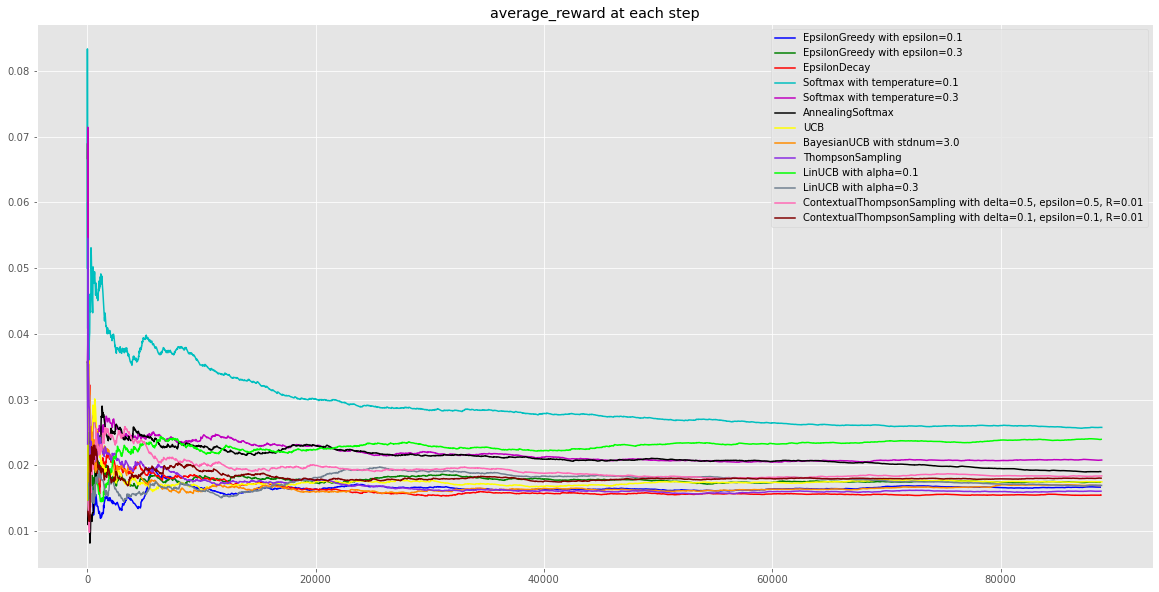

In [68]:
present_results(las_vegas_results, 'average_reward')

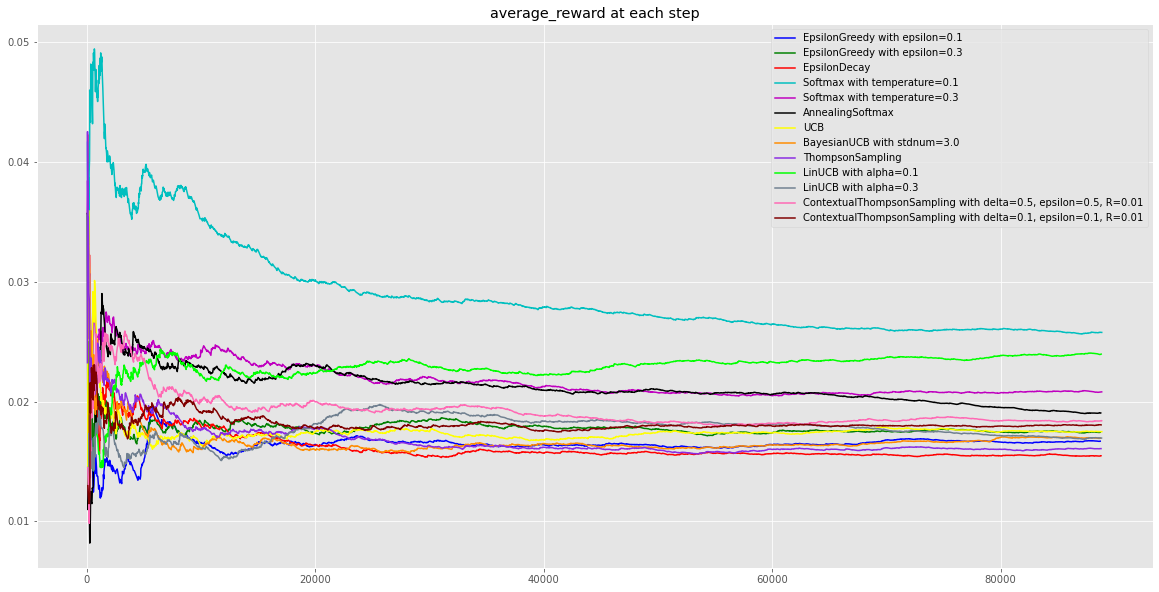

In [69]:
present_results(las_vegas_results[las_vegas_results['average_reward'] < 0.05], 'average_reward')

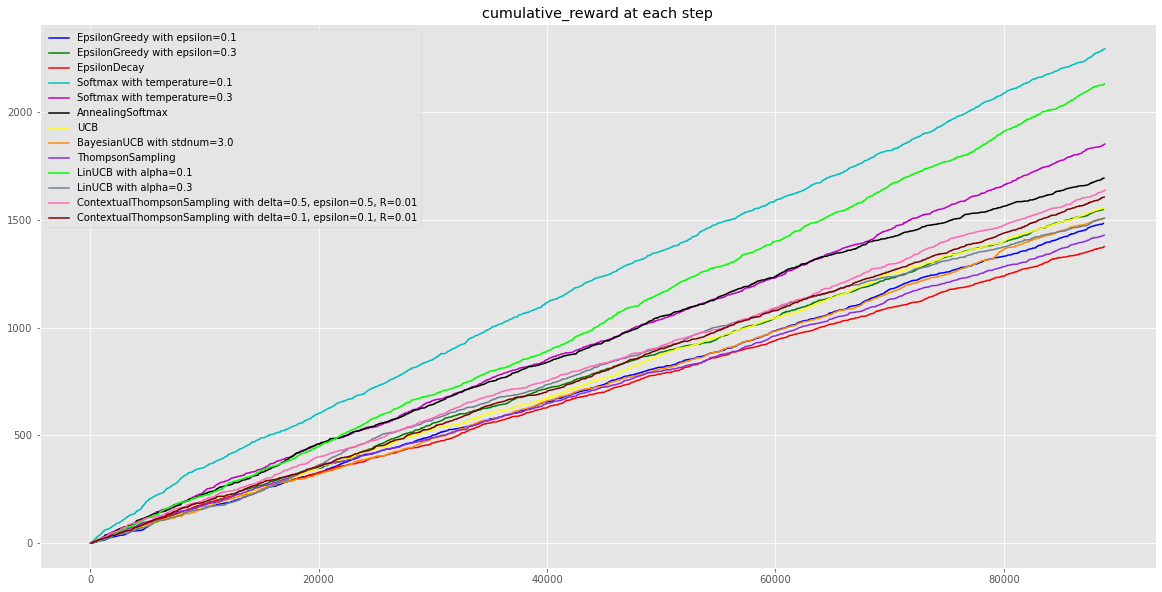

In [70]:
present_results(las_vegas_results, 'cumulative_reward')

### Toronto

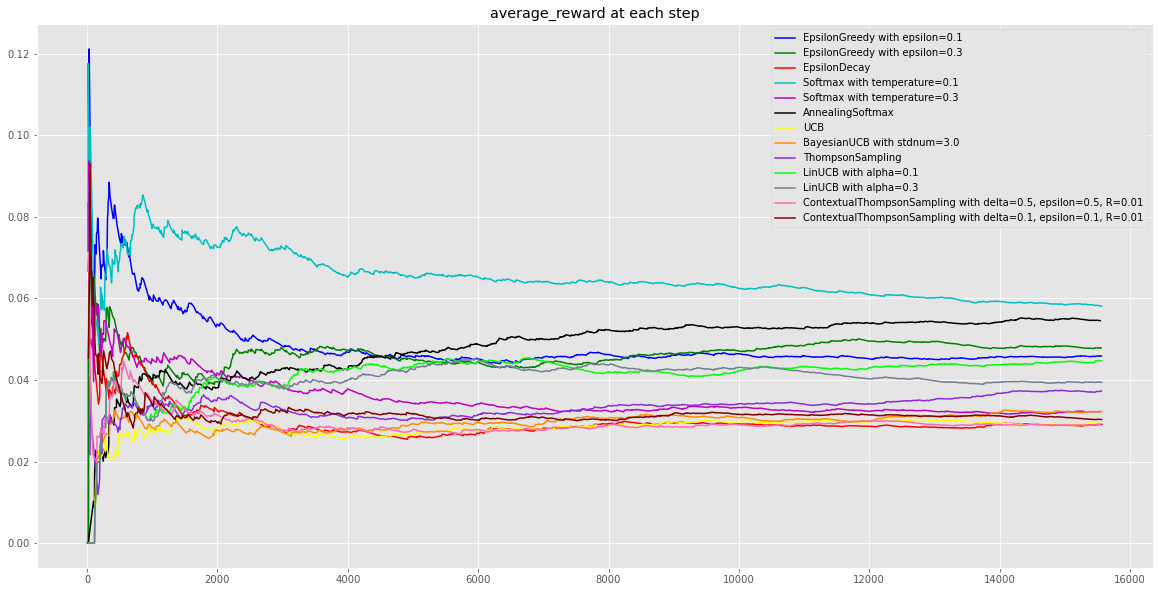

In [71]:
present_results(toronto_results, 'average_reward')

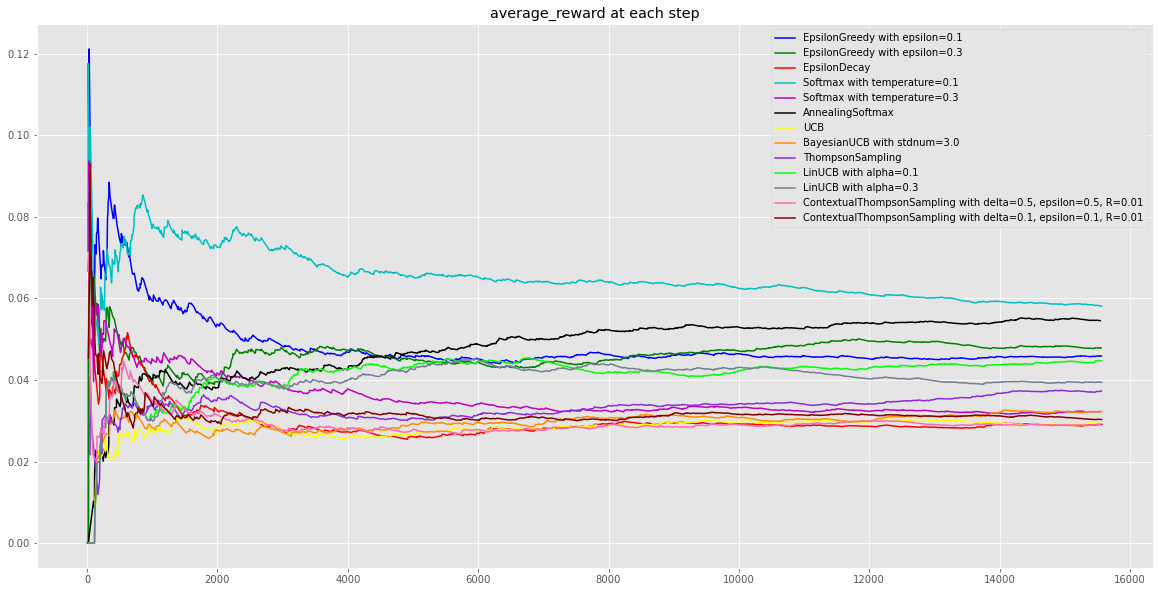

In [74]:
present_results(toronto_results[toronto_results['average_reward'] < 0.2], 'average_reward')

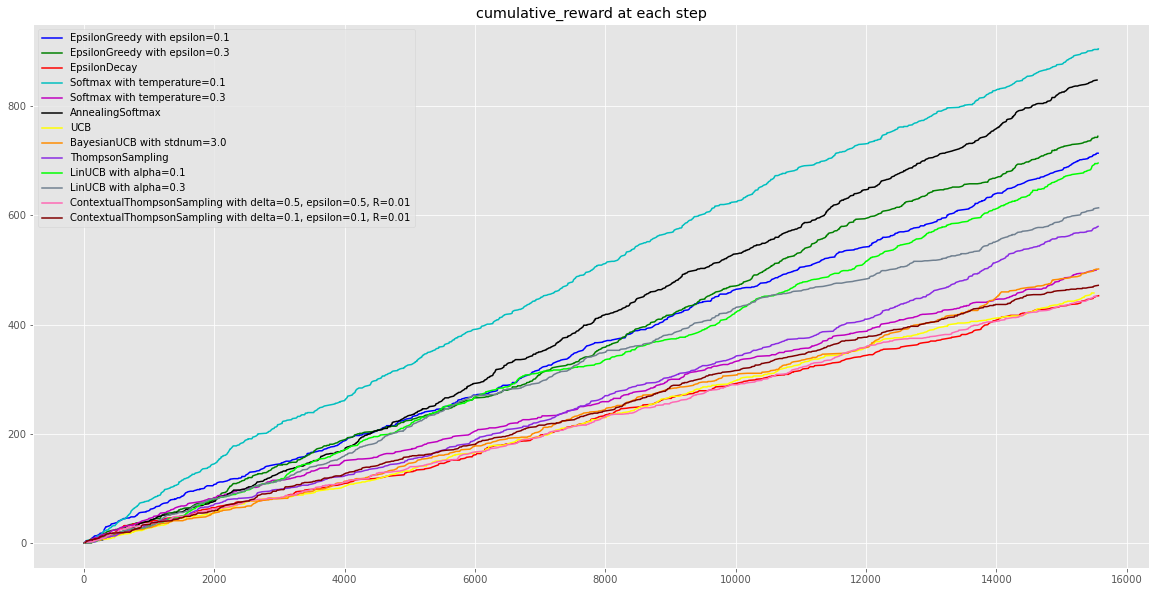

In [75]:
present_results(toronto_results, 'cumulative_reward')